<a href="https://colab.research.google.com/github/qusai406/DS230-Final-Project/blob/main/04_modeling_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Google Drive Link**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Library Import**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

# **Data path on Drive**

In [3]:
DATA = '/content/drive/MyDrive/DS230_data/'

# Data **Loading**

In [4]:
orders = pd.read_csv(DATA + 'orders.csv')
order_products = pd.read_csv(DATA + 'order_products__prior.csv')
products = pd.read_csv(DATA + 'products.csv')
aisles = pd.read_csv(DATA + 'aisles.csv')
departments = pd.read_csv(DATA + 'departments.csv')

# **Data Merge**

In [5]:
df = order_products.merge(orders, on="order_id", how="left")
df = df.merge(products, on="product_id", how="left")

df.head()


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13


# **Sampling**

In [6]:
df_eda = df.sample(n=100000, random_state=42)
df_eda.shape

(100000, 13)

# **Post merge EDA**

In [7]:
df_eda.shape
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 29481110 to 32288685
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                100000 non-null  int64  
 1   product_id              100000 non-null  int64  
 2   add_to_cart_order       100000 non-null  int64  
 3   reordered               100000 non-null  int64  
 4   user_id                 100000 non-null  int64  
 5   eval_set                100000 non-null  object 
 6   order_number            100000 non-null  int64  
 7   order_dow               100000 non-null  int64  
 8   order_hour_of_day       100000 non-null  int64  
 9   days_since_prior_order  93634 non-null   float64
 10  product_name            100000 non-null  object 
 11  aisle_id                100000 non-null  int64  
 12  department_id           100000 non-null  int64  
dtypes: float64(1), int64(10), object(2)
memory usage: 10.7+ MB


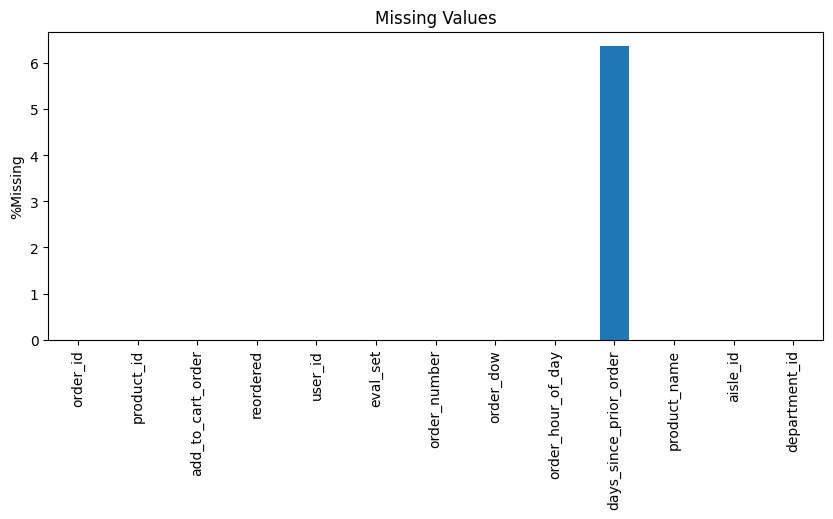

In [8]:
#Missing values

df_eda.isna().sum()
(df_eda.isna().mean() * 100).plot(kind="bar",figsize=(10,4))
plt.title("Missing Values")
plt.ylabel("%Missing")
plt.show()


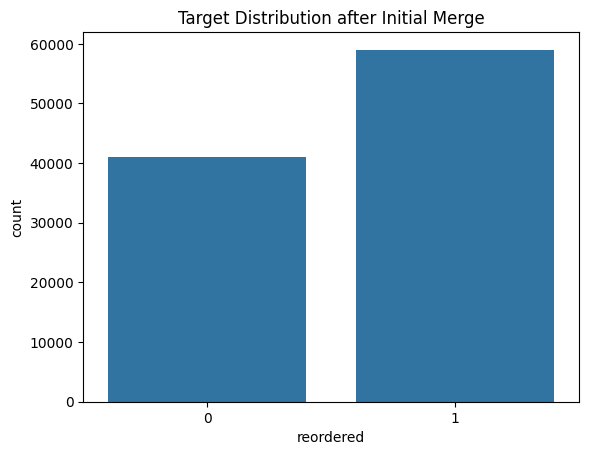

Reorder rate: 0.59006


In [9]:
#Target Distribution
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x="reordered", data=df_eda)
plt.title("Target Distribution after Initial Merge")
plt.show()

print("Reorder rate:", df_eda["reordered"].mean())

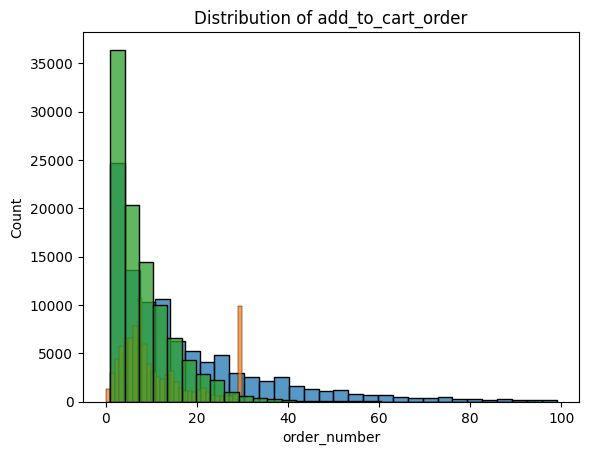

In [10]:
#Pairwise Numeric
num_cols = [
    "order_number",
    "days_since_prior_order",
    "add_to_cart_order",

]

for col in num_cols:
  sns.histplot(df_eda[col].dropna(),bins=30)
  plt.title(f"Distribution of {col}")
plt.show()


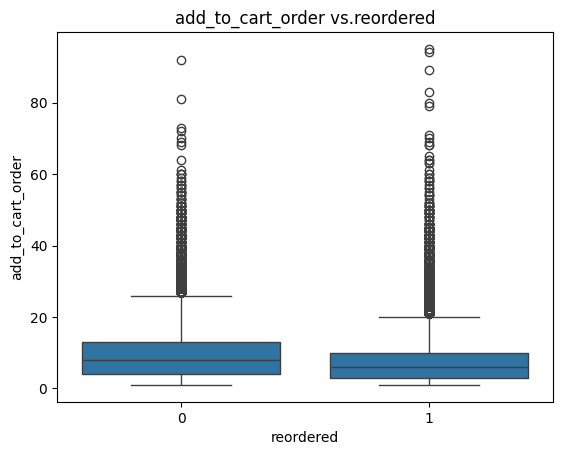

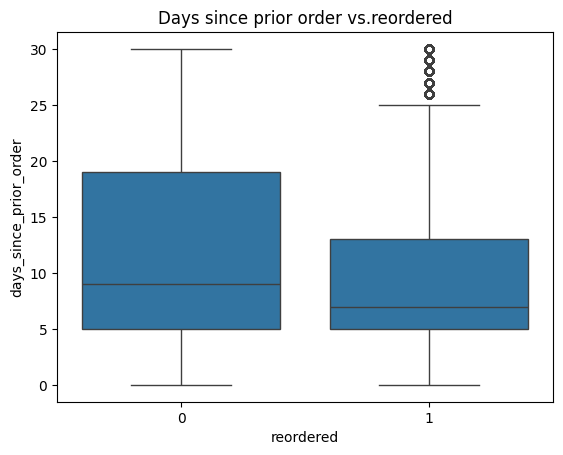

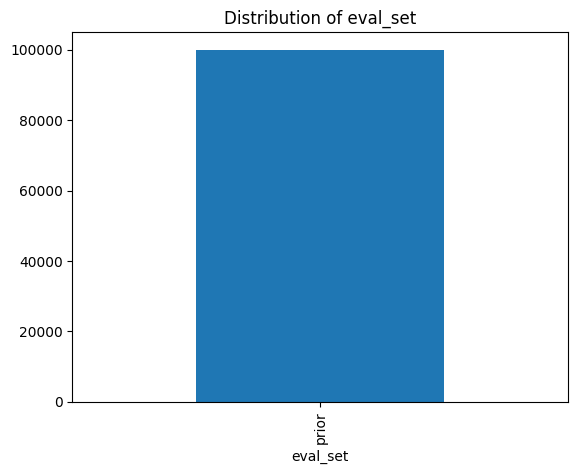

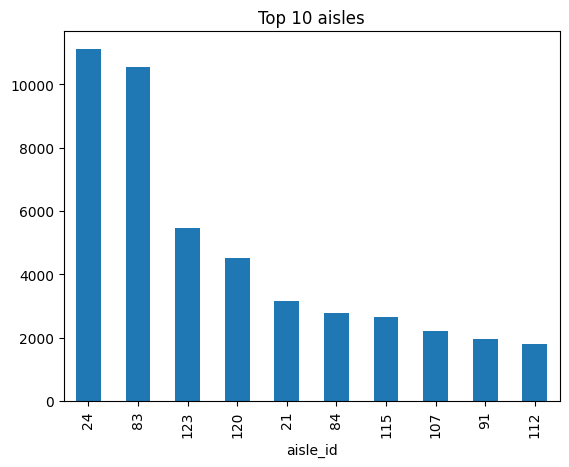

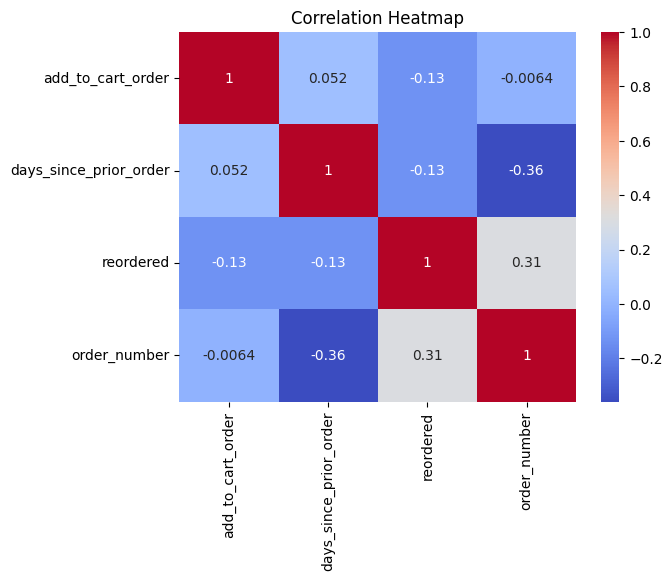

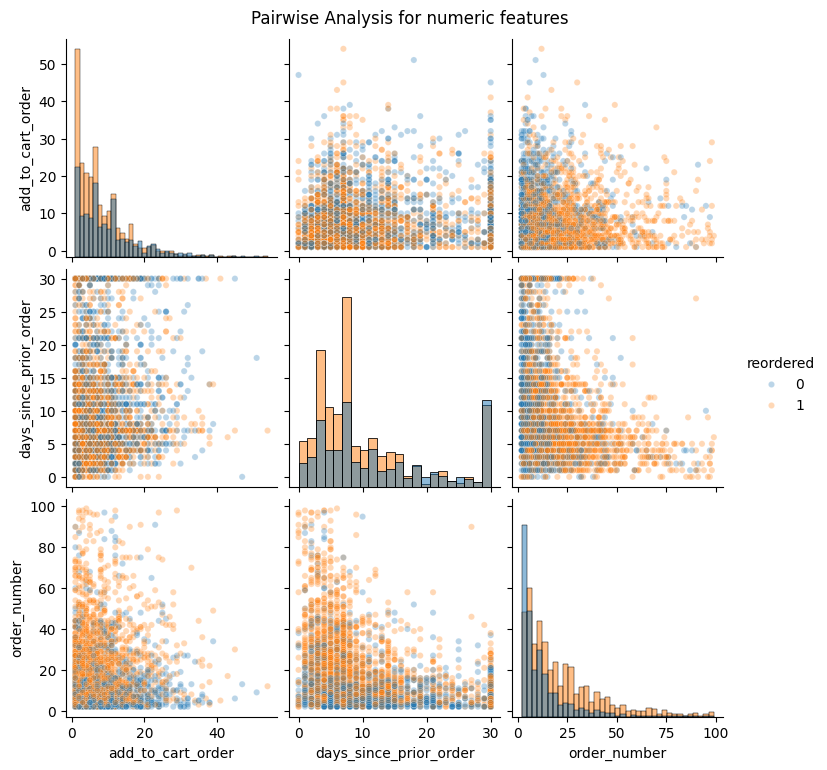

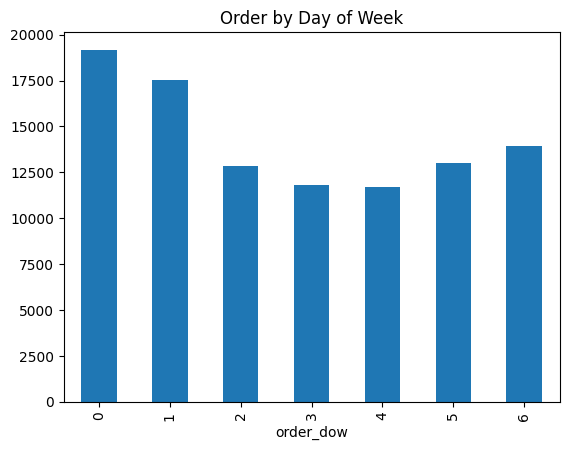

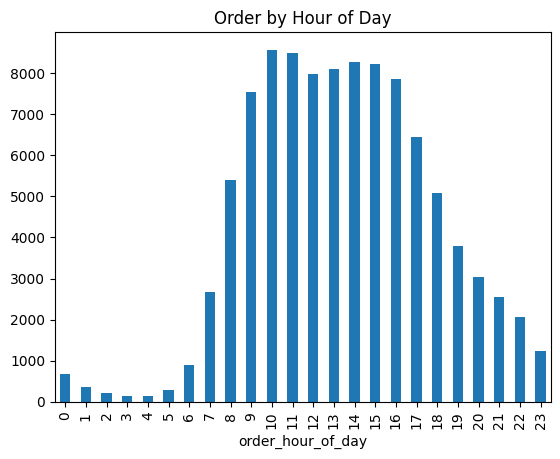

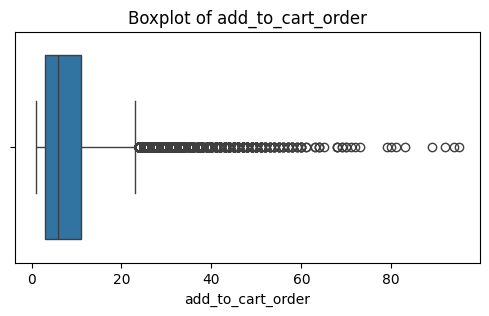

add_to_cart_order → Outlier Count: 4262


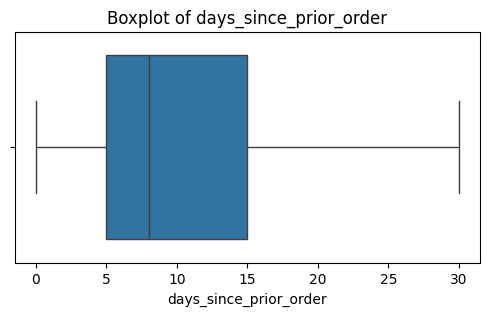

days_since_prior_order → Outlier Count: 0


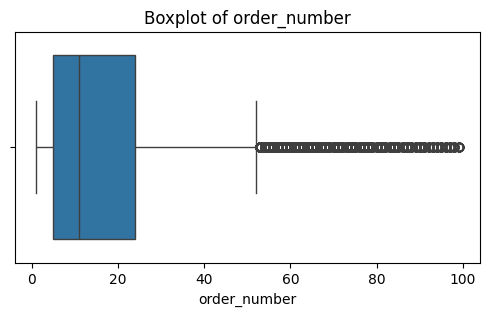

order_number → Outlier Count: 5382


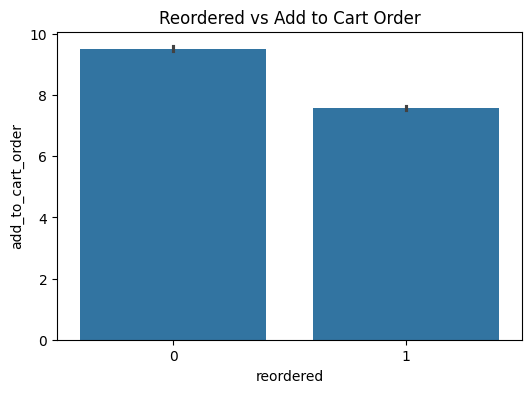

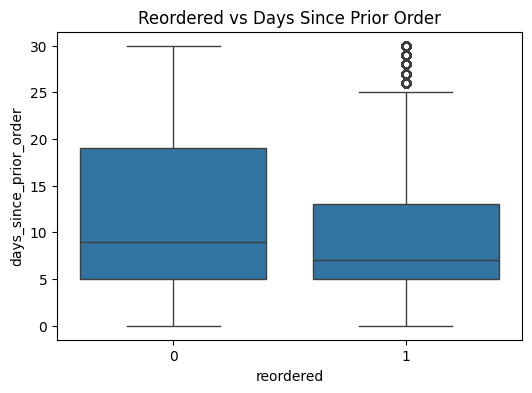

Memory before optimization: 21.372032165527344 MB
Memory after optimization: 15.268516540527344 MB


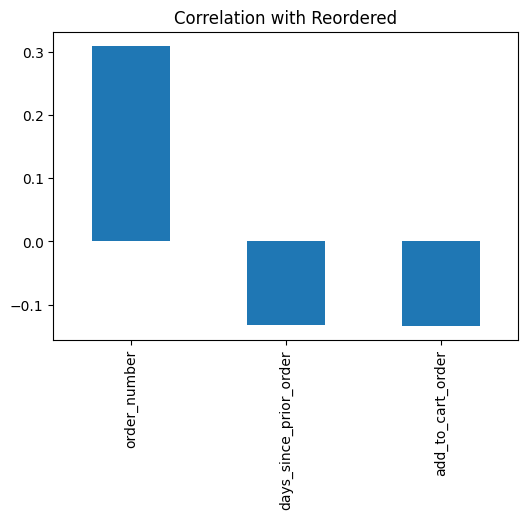

In [11]:
from copy import deepcopy
##add_to_cart_order##
sns.boxplot(x="reordered", y="add_to_cart_order", data=df_eda)
plt.title("add_to_cart_order vs.reordered")
plt.show()

##days_since_prior_order##
sns.boxplot(x="reordered", y="days_since_prior_order", data=df_eda)
plt.title("Days since prior order vs.reordered")
plt.show()


##eval_set##
df_eda["eval_set"].value_counts().plot(kind="bar")
plt.title("Distribution of eval_set")
plt.show()



##10 aisles##
df_eda["aisle_id"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 aisles")
plt.show()


##correlation##
corr_cols = ["add_to_cart_order", "days_since_prior_order", "reordered","order_number"]
sns.heatmap(df_eda[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


##Pairwise analysis##
pair_cols = ["add_to_cart_order", "days_since_prior_order", "reordered","order_number"]
sns.pairplot(df_eda[pair_cols].dropna().sample(3000, random_state=42),hue="reordered",diag_kind="hist",plot_kws={"alpha":0.3,"s":20})
plt.suptitle("Pairwise Analysis for numeric features", y=1.02)
plt.show()


##Time-based-EDA##
df_eda["order_dow"].value_counts().sort_index().plot(kind="bar")
plt.title("Order by Day of Week")
plt.show()

df_eda["order_hour_of_day"].value_counts().sort_index().plot(kind="bar")
plt.title("Order by Hour of Day")
plt.show()


#Outlier Analysis
num_cols = ["add_to_cart_order", "days_since_prior_order", "order_number"]

for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_eda[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

    q1 = df_eda[col].quantile(0.25)
    q3 = df_eda[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    outliers = df_eda[(df_eda[col] < lower) | (df_eda[col] > upper)]
    print(f"{col} → Outlier Count:", outliers.shape[0])



#Target vs Features Analysis
plt.figure(figsize=(6, 4))
sns.barplot(x="reordered", y="add_to_cart_order", data=df_eda)
plt.title("Reordered vs Add to Cart Order")
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x="reordered", y="days_since_prior_order", data=df_eda)
plt.title("Reordered vs Days Since Prior Order")
plt.show()


#Memory Optimization
def memory_usage(df):
    return df.memory_usage(deep=True).sum() / 1024**2
print("Memory before optimization:", memory_usage(df_eda), "MB")

for col in df_eda.select_dtypes(include=["int64"]).columns:
    df_eda[col] = pd.to_numeric(df_eda[col], downcast="integer")

for col in df_eda.select_dtypes(include=["float64"]).columns:
    df_eda[col] = pd.to_numeric(df_eda[col], downcast="float")

print("Memory after optimization:", memory_usage(df_eda), "MB")



#Correlation with Target
corr_target=df_eda[num_cols + ["reordered"]].corr()["reordered"].sort_values(ascending=False)
plt.figure(figsize=(6, 4))
corr_target.drop("reordered").plot(kind="bar")
plt.title("Correlation with Reordered")
plt.show()




# Final **Merging**

In [12]:
df_eda = df_eda.merge(aisles, on="aisle_id", how="left")
df_eda = df_eda.merge(departments, on="department_id", how="left")
df_eda.head()
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                100000 non-null  int32  
 1   product_id              100000 non-null  int32  
 2   add_to_cart_order       100000 non-null  int8   
 3   reordered               100000 non-null  int8   
 4   user_id                 100000 non-null  int32  
 5   eval_set                100000 non-null  object 
 6   order_number            100000 non-null  int8   
 7   order_dow               100000 non-null  int8   
 8   order_hour_of_day       100000 non-null  int8   
 9   days_since_prior_order  93634 non-null   float32
 10  product_name            100000 non-null  object 
 11  aisle_id                100000 non-null  int16  
 12  department_id           100000 non-null  int8   
 13  aisle                   100000 non-null  object 
 14  department           

# **Feature Engineering**

In [13]:
from os import name
## User-Level Features ##
df_feat = df_eda.copy()
user_total_orders = df_feat.groupby("user_id")["order_number"].max()
user_total_orders = user_total_orders.reset_index()
user_total_orders.columns = ["user_id", "user_total_orders"]
user_total_orders.head()
#حساب اجمالي عدد الطلبات لكل مستخدم

basket_size = df_feat.groupby(["user_id", "order_id"])["product_id"].count()
basket_size = basket_size.reset_index()
basket_size.columns = ["user_id", "order_id", "basket_size"]
#حساب عدد المنتجات في كل طلب لكل مستخدم

user_avg_basket = basket_size.groupby("user_id")["basket_size"].mean()
user_avg_basket = user_avg_basket.reset_index()
user_avg_basket.columns = ["user_id", "user_avg_basket_size"]
user_avg_basket.head()
#حساب متوسط حجم سلة التسوق لكل مستخدم

user_reorder_ratio = df_feat.groupby("user_id")["reordered"].mean()
user_reorder_ratio = user_reorder_ratio.reset_index()
user_reorder_ratio.columns = ["user_id", "user_reorder_ratio"]
user_reorder_ratio.head()
#حساب نسبة إعادة الطلب لكل مستخدم


user_mean_days = df_feat.groupby("user_id")["days_since_prior_order"].mean()
user_mean_days = user_mean_days.reset_index()
user_mean_days.columns = ["user_id", "user_mean_days_since_prior"]
user_mean_days.head()
#حساب متوسط عدد الايام بين الطلبات لكل مستخدم


user_recency = df_feat.groupby("user_id")["days_since_prior_order"].last()
user_recency = user_recency.reset_index()
user_recency.columns = ["user_id", "user_last_order_recency"]
user_recency.head()
#حساب عدد الايام من اخر طلب لكل مستخدم


user_features = user_total_orders.merge(user_avg_basket, on="user_id", how="left")
user_features = user_features.merge(user_reorder_ratio, on="user_id", how="left")
user_features = user_features.merge(user_mean_days, on="user_id" , how="left")
user_features = user_features.merge(user_recency, on="user_id", how="left")
user_features.head()
#دمج جميع ميزات مستوى المستخدم في إطار بيانات واحد



## product-level Features ##
product_orders = df_feat.groupby("product_id")["order_id"].count()
product_orders = product_orders.reset_index()
product_orders.columns = ["product_id", "product_total_orders"]
product_orders.head()
#إجمالي عدد مرات شراء كل منتج

product_reorder_rate = df_feat.groupby("product_id")["reordered"].mean()
product_reorder_rate = product_reorder_rate.reset_index()
product_reorder_rate.columns = ["product_id", "product_reorder_rate"]
product_reorder_rate.head()
#نسبة مرات إعادة طلب المنتج

product_cart_position = df_feat.groupby("product_id")["add_to_cart_order"].mean()
product_cart_position = product_cart_position.reset_index()
product_cart_position.columns = ["product_id", "product_avg_cart_position"]
product_cart_position.head()
#متوسط موقع المنتج في سلة السوق

product_features = product_orders.merge(product_reorder_rate, on="product_id", how="left")
product_features = product_features.merge(product_cart_position, on="product_id", how="left")
product_features.head()
#دمج جميع ميزات المنتج في إطار بيانات واحد


## user * product features ##
user_product_count = (
    df_feat.groupby(["user_id", "product_id"])["order_id"]
    .count()
    .reset_index(name="user_product_purchase_count")
)
user_product_count.head()
#حساب عدد مرات الشراء كل مستخدم لكل منتج


user_product_reorder_rate = (
    df_feat.groupby(["user_id", "product_id"])["reordered"]
    .mean()
    .reset_index(name="user_product_reorder_rate")
)
user_product_reorder_rate.head()
#حساب نسبة اعادة طلب مستخدم لكل منتج


df_feat_sorted = df_feat.sort_values(["user_id", "product_id", "order_number"])
user_product_last_day = (
    df_feat_sorted.groupby(["user_id", "product_id"])["days_since_prior_order"]
    .last()
    .reset_index(name = "user_product_days_since_last_purchase")
)
user_product_last_day.head()
#حساب عدد الايام من اخر عملية شراء كل مستخدم لكل منتج


user_product_features = (
    user_product_count
        .merge(user_product_reorder_rate, on=["user_id", "product_id"], how="left")
        .merge(user_product_last_day, on=["user_id", "product_id"], how="left")
)
user_product_features.head()
#دمج ميزات المستخدم مع المنتج في إطار بيانات واحد



## Temporal Features ##
temporal_features = df_feat[["order_id", "user_id", "order_dow", "order_hour_of_day"]].drop_duplicates()
#ايجاد ميزات زمنيه مثل يوم الطلب وساعة الطلب

temporal_features["is_weekend"] = temporal_features["order_dow"].isin([0,6]).astype(int)
#انشاء متغير بحدد اذا الطلب في علطة نهاية الاسبوع او لا

def time_of_day(hour):
    if 5 <= hour < 12:
      return "morning"
    elif 12 <= hour < 17:
      return "afternoon"
    elif 17 <= hour < 21:
      return "evening"
    else:
      return "night"

temporal_features["time_of_day"] = temporal_features["order_hour_of_day"].apply(time_of_day)
#تقسيم وقت الطلب لفترات

time_map = {"morning":0, "afternoon":1, "evening":2, "night":3}
temporal_features["time_of_day_code"] = temporal_features["time_of_day"].map(time_map)
#تحويل الفترات الزمنية لفترات رقمية

df_feat = df_feat.merge(temporal_features[["order_id", "is_weekend", "time_of_day_code"]], on="order_id", how="left")
df_feat[["order_id", "is_weekend", "time_of_day_code"]].head()
#دمج الفترات الزمنيه مع اطار البيانات الرئيسي


## Non-linear features
#log transforms
df_feat = df_feat.merge(user_features[["user_id", "user_total_orders"]],on="user_id",how="left")
df_feat["log_user_total_orders"] = np.log1p(df_feat["user_total_orders"])
#هون اخترت احول لوغاريتمي عشان اقلل انحراف عدد الطلبات


##Encoding-Categorical-Variables
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ohe_features = ohe.fit_transform(df_feat[[ "department", "aisle"]])
ohe_features_names = ohe.get_feature_names_out(["department", "aisle"])
ohe_df = pd.DataFrame(ohe_features, columns=ohe_features_names, index=df_feat.index)
df_feat = pd.concat([df_feat, ohe_df], axis=1)
#تحويل القيم النصيه لأعمدة رقمية

global_mean = df_feat["reordered"].mean()
product_mean = df_feat.groupby("product_id")["reordered"].mean()
product_count = df_feat.groupby("product_id")["reordered"].count()
smoothing = 10
product_target_enc = (product_mean * product_count + global_mean * smoothing) / (product_count + smoothing)
df_feat["product_target_enc"] = df_feat["product_id"].map(product_target_enc)
#بمثل كل منتج بقيمة رقميه عشان تعكس احتمال طلبه

user_freq = df_feat["user_id"].value_counts(normalize=True)
df_feat["user_freq"] = df_feat["user_id"].map(user_freq)
#بمثل كل مستخدم بقيمه رقميه عشان اشوف عدد تكراره في البيانات





# **Feature Scaling**

In [14]:
from sklearn.preprocessing import StandardScaler

numeric_features = df_feat.select_dtypes(include=["int64", "float64"])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)
scaled_df = pd.DataFrame(scaled_features, columns=numeric_features.columns,index=df_feat.index)
scaled_df.head()
#وحدت القيم الرقمية على نفس المقاييس

,is_weekend,time_of_day_code,department_alcohol,department_babies,department_bakery,department_beverages,department_breakfast,department_bulk,department_canned goods,department_dairy eggs,department_deli,department_dry goods pasta,department_frozen,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,aisle_baking ingredients,aisle_baking supplies decor,aisle_beauty,aisle_beers coolers,aisle_body lotions soap,aisle_bread,aisle_breakfast bakery,aisle_breakfast bars pastries,aisle_bulk dried fruits vegetables,aisle_bulk grains rice dried goods,aisle_buns rolls,aisle_butter,aisle_candy chocolate,aisle_canned fruit applesauce,aisle_canned jarred vegetables,aisle_canned meals beans,aisle_canned meat seafood,aisle_cat food care,aisle_cereal,aisle_chips pretzels,aisle_cleaning products,aisle_cocoa drink mixes,aisle_coffee,aisle_cold flu allergy,aisle_condiments,aisle_cookies cakes,aisle_crackers,aisle_cream,aisle_deodorants,aisle_diapers wipes,aisle_digestion,aisle_dish detergents,aisle_dog food care,aisle_doughs gelatins bake mixes,aisle_dry pasta,aisle_eggs,aisle_energy granola bars,aisle_energy sports drinks,aisle_eye ear care,aisle_facial care,aisle_feminine care,aisle_first aid,aisle_food storage,aisle_fresh dips tapenades,aisle_fresh fruits,aisle_fresh herbs,aisle_fresh pasta,aisle_fresh vegetables,aisle_frozen appetizers sides,aisle_frozen breads doughs,aisle_frozen breakfast,aisle_frozen dessert,aisle_frozen juice,aisle_frozen meals,aisle_frozen meat seafood,aisle_frozen pizza,aisle_frozen produce,aisle_frozen vegan vegetarian,aisle_fruit vegetable snacks,aisle_grains rice dried goods,aisle_granola,aisle_hair care,aisle_honeys syrups nectars,aisle_hot cereal pancake mixes,aisle_hot dogs bacon sausage,aisle_ice cream ice,aisle_ice cream toppings,aisle_indian foods,aisle_instant foods,aisle_juice nectars,aisle_kitchen supplies,aisle_kosher foods,aisle_latino foods,aisle_laundry,aisle_lunch meat,aisle_marinades meat preparation,aisle_meat counter,aisle_milk,aisle_mint gum,aisle_missing,aisle_more household,aisle_muscles joints pain relief,aisle_nuts seeds dried fruit,aisle_oils vinegars,aisle_oral hygiene,aisle_other,aisle_other creams cheeses,aisle_packaged cheese,aisle_packaged meat,aisle_packaged poultry,aisle_packaged produce,aisle_packaged seafood,aisle_packaged vegetables fruits,aisle_paper goods,aisle_pasta sauce,aisle_pickled goods olives,aisle_plates bowls cups flatware,aisle_popcorn jerky,aisle_poultry counter,aisle_prepared meals,aisle_prepared soups salads,aisle_preserved dips spreads,aisle_protein meal replacements,aisle_red wines,aisle_refrigerated,aisle_refrigerated pudding desserts,aisle_salad dressing toppings,aisle_seafood counter,aisle_shave needs,aisle_skin care,aisle_soap,aisle_soft drinks,aisle_soup broth bouillon,aisle_soy lactosefree,aisle_specialty cheeses,aisle_specialty wines champagnes,aisle_spices seasonings,aisle_spirits,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt,product_target_enc,user_freq
0,1.421928,1.114079,-0.070674,-0.116542,-0.193191,-0.301742,-0.150157,-0.032575,-0.18453,-0.452409,-0.182697,-0.163705,-0.269452,-0.15213,-0.092094,-0.146958,-0.044202,-0.033185,4.024170,-0.118249,-0.054487,-0.641073,-0.312118,-0.025699,-0.070959,-0.016434,-0.018169,-0.109975,-0.03594,-0.100555,-0.029167,-0.01304,-0.038107,-0.034517,-0.135426,-0.086285,-0.046634,-0.023881,-0.022141,-0.059688,-0.087916,-0.096255,-0.052417,-0.09599,-0.090927,-0.045212,-0.045434,-0.109929,-0.149913,-0.05994,-0.025893,-0.080194,-0.028472,-0.084262,-0.085338,-0.11959,-0.1

# **Train-Validation split**

In [15]:
#Time-aware
df_feat["max_order_number"] = df_feat.groupby("user_id")["order_number"].transform("max")

train_df = df_feat[df_feat["order_number"] < df_feat["max_order_number"]]
val_df = df_feat[df_feat["order_number"] == df_feat["max_order_number"]]

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
#قسمنا البيانات من حيث الزمن عشان النموذج يتم بناءه على الطلبات اللي قبل ونختبره على اخر طلب لكل مستخدم عشان نتجنب تسريب المعلومات لانه يمكن يشوف معلومات من المستقبل وهيك بتصير النتائج مش واقعية

Train shape: (35742, 177)
Validation shape: (64258, 177)


# **Modeling**

## Classfication (Task A)

**Logistic Regression - Baseline Model**

Target variable

In [16]:
y_train = train_df["reordered"]
y_val   = val_df["reordered"]


drop_cols = ["reordered", "max_order_number"]
X_train = train_df.drop(columns=drop_cols)
X_val   = val_df.drop(columns=drop_cols)
#فصل متغير الهدف عن ميزات الادخال


Remove non-numeric (string) columns

أزلت اعمدة السلاسل التصنيفيه بعد الترميز عشان أضمن انه تكون جميع المدخلات رقمية وموافقة مع مصنفات مستخدمة

In [17]:
non_numeric_cols = X_train.select_dtypes(include=["object"]).columns
X_train = X_train.drop(columns=non_numeric_cols)
X_val   = X_val.drop(columns=non_numeric_cols)

print("Non-numeric columns removed:", list(non_numeric_cols))
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


Non-numeric columns removed: ['eval_set', 'product_name', 'aisle', 'department']
X_train shape: (35742, 171)
X_val shape: (64258, 171)


sampling

عشان اخفف من قيود الذاكرة اثناء تدريب النموذج

In [18]:
X_train = X_train.sample(frac=0.3, random_state=42)
y_train = y_train.loc[X_train.index]


Logistic Regreission

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import pandas as pd


imputer = SimpleImputer(strategy='median')



X_train_imputed_array = imputer.fit_transform(X_train)
X_val_imputed_array = imputer.transform(X_val)


X_train_imputed = pd.DataFrame(X_train_imputed_array, columns=X_train.columns, index=X_train.index)
X_val_imputed = pd.DataFrame(X_val_imputed_array, columns=X_val.columns, index=X_val.index)


log_model = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs = -1)
log_model.fit(X_train_imputed, y_train)
#تدريب نموذج الانحدار اللوجيستي كاساس للتنبؤ باعادة الطلب
#استخدمت(logistic regression)
#لانه مناسب لمشاكل التصنيف الثنائي
#سهل التفسير وبتعامل مع الاحتمالات لهيك هو مناسب للتنبؤ

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

Evaluation Metrics

In [20]:
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix)

y_pred = log_model.predict(X_val_imputed)
y_pred_proba = log_model.predict_proba(X_val_imputed)[:,1]

print("Classification Report:\n", classification_report(y_val, y_pred))

roc_auc = roc_auc_score(y_val, y_pred_proba)
print("ROC AUC:", roc_auc)

confusion_matrix(y_val, y_pred)
#تقييم اداء النموذج بستخدام مقاييس التصنيف

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.76      0.65     27680
           1       0.76      0.57      0.65     36578

    accuracy                           0.65     64258
   macro avg       0.67      0.67      0.65     64258
weighted avg       0.68      0.65      0.65     64258

ROC AUC: 0.7333234710715593


array([[21138,  6542],
       [15861, 20717]])

ROC Curve

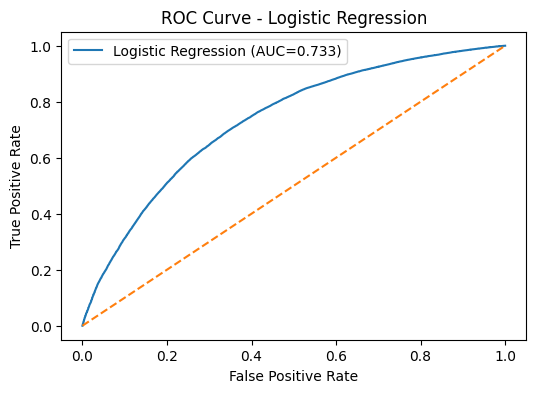

In [21]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()
#رسم منحنى عشان يتصور اداء الانحدارROC
#استخدم الانحدار اللوجستي كنموذج تصنيف أساسي لبساطته وسهولة تفسيره وقوته في التعامل مع مساحات الميزات عالية الأبعاد.
#هو يوفر نقطة مرجعية واضحة لتقييم أداء النماذج الأكثر تعقيد


**XGBoost Classfication Model**



 اخترته كنموذج تصنيف لانه ادائها قوي على البيانات الجدولية وبرضو لقدرته على استيعاب العلاقات غير الخطية المعقدة وتمت مقارنته بخط اساس خطي عشان تقيّم تحسينات الأداء الناتجة عن زيادة تعقيد النموذج

In [22]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, objective="binary:logistic", eval_metric="auc", random_state=42, n_jobs=-1)

xgb_model.fit(X_train, y_train)

from sklearn.metrics import classification_report, roc_auc_score

xgb_pred = xgb_model.predict(X_val)
xgb_pred_proba = xgb_model.predict_proba(X_val)[:, 1]

print("XGBoost Classification Report:\n", classification_report(y_val, xgb_pred))

xgb_roc_auc = roc_auc_score(y_val, xgb_pred_proba)
print("XGBoost ROC AUC:", xgb_roc_auc)

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.67      0.71     27680
           1       0.77      0.85      0.81     36578

    accuracy                           0.77     64258
   macro avg       0.77      0.76      0.76     64258
weighted avg       0.77      0.77      0.77     64258

XGBoost ROC AUC: 0.8424308087404949


**Comparison ROC Curve**

مقارنة منحنى ROC
مع الانحدار اللوجستي باستخدام
XGBoost

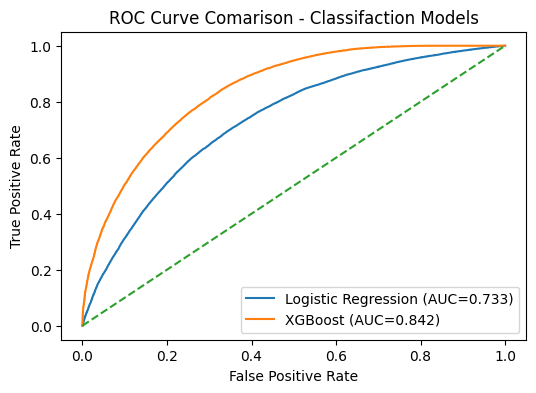

In [23]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

xgb_auc = roc_auc_score(y_val, xgb_pred_proba)
fqr_xgb, tqr_xgb, _ = roc_curve(y_val, xgb_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC={roc_auc:.3f})")
plt.plot(fqr_xgb, tqr_xgb, label=f"XGBoost (AUC={xgb_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comarison - Classifaction Models")
plt.legend()
plt.show()

# **Evaluation & Explainability**

 Feature Importance - XGBoost


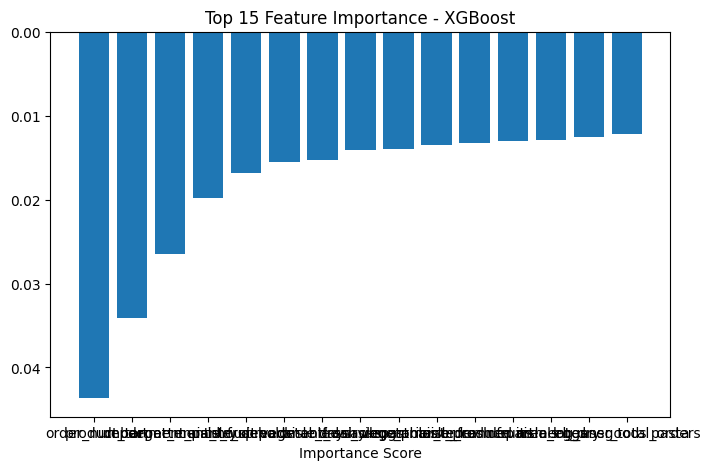

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({"feature": X_train.columns, "importance": importance}).sort_values(by="importance", ascending=False)

feature_importance_df.head(10)


plt.figure(figsize=(8, 5))
plt.bar(feature_importance_df["feature"].head(15), feature_importance_df["importance"].head(15))
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Top 15 Feature Importance - XGBoost")
plt.show()


التحليل بوضح انه تصرفات المستخدم زي اعادة الطلب وشعبية المنتج الها دور كبير بتوقع اذا رح ينطلب مرة ثانية وكمان عامل الوقت اله تأثير لانه نمط الطلب بفرق بقرار النموذج

### Model Comparison Summary
نموذج XGBoost تفوق على نموذج الانحدار اللوجستي من ناحية الأداء حسب منحنى ROC لأنه بعرف يتعامل مع العلاقات المعقدة بين الخصائص وبحسن التوقعات مع هيك الانحدار اللوجستي بعده مهم لأنه سهل الفهم ويعتبر أساس قوي